<a href="https://colab.research.google.com/github/SGRGit/gwOsc/blob/master/CreateSampleSignalProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import scipy

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

#Fs = 1e3;  # sampling rate
#Ts = 1.0/Fs; # sampling interval
#t = np.arange(0,1, Ts) # time vector

fs = 1e4
fr = np.float(50.0)
N = 1e3
fr = 100.0
t = np.arange(N) / fs

#t = np.linspace(0, 60, 50)
#a = 1e-18
a = 5
x = a*np.sin(2*np.pi*fr*t) + a*np.cos(2*np.pi*fr*t)
n = 1e2*np.random.randn(len(t))
xn = x + np.random.randn(len(t))

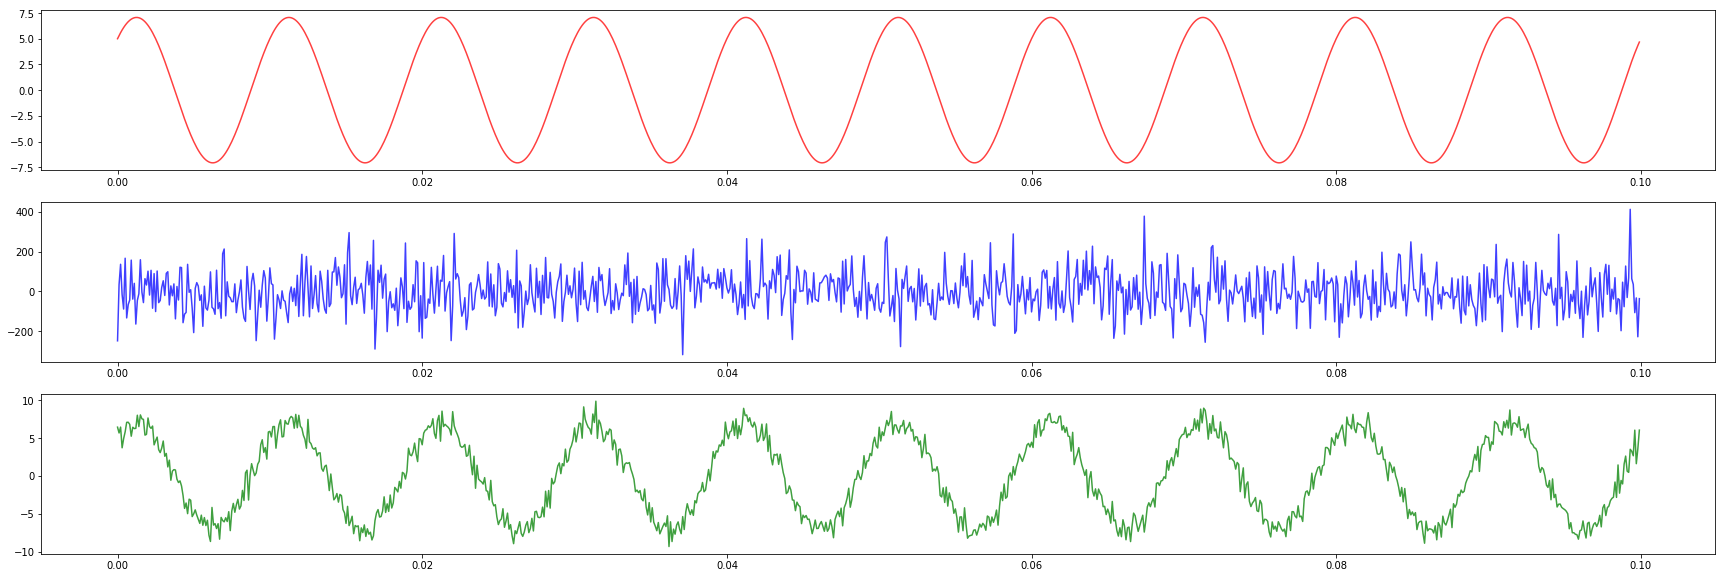

In [49]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
f.set_figwidth(30)
f.set_figheight(10)
ax1.plot(t, x, 'r' , alpha=0.75)

ax2.plot(t, n, 'b', alpha=0.75)

ax3.plot(t, xn, 'g', alpha=0.75)


[(1, 2000)]

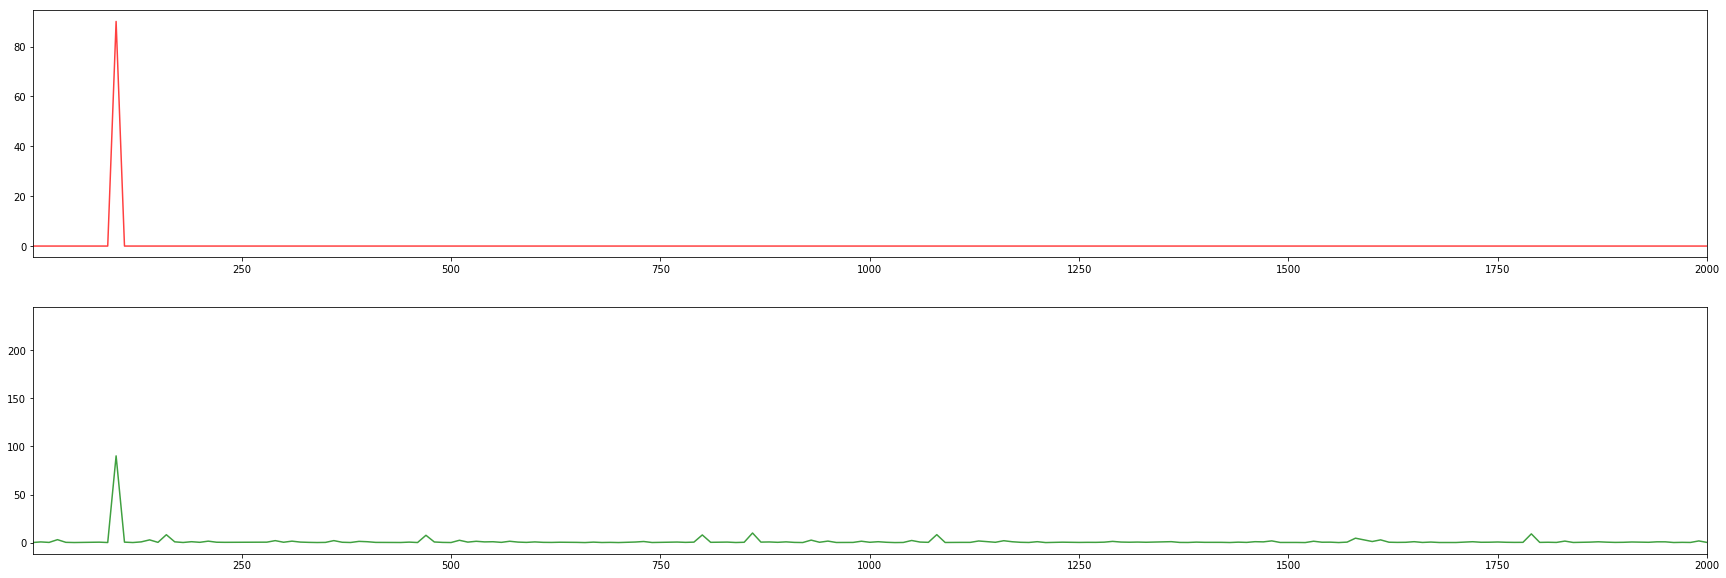

In [50]:
#noise + signal
s = len(xn) 
k = np.arange(s)
T = s/fs
frq = k/T # two sides frequency range
frq = frq[range(int(s/2))] # one side frequency range
Y = np.fft.fft(xn)/n # fft computing and normalization
Y = Y[range(int(s/2))]

# signal
ss = len(x) 
ks = np.arange(ss)
Ts = ss/fs
frqs = ks/T # two sides frequency range
frqs = frq[range(int(ss/2))] # one side frequency range
Ys = np.fft.fft(x)/n # fft computing and normalization
Ys = Ys[range(int(ss/2))]


#plt.plot(frq, abs(Y))

ft, (axft1, axft2) = plt.subplots(2, 1)
ft.set_figwidth(30)
ft.set_figheight(10)
axft1.plot(frqs, abs(Ys), 'r' , alpha=0.75)
axft2.plot(frq, abs(Y), 'g', alpha=0.75)
axft1.axes.set(xlim = (1, 2000))
axft2.axes.set(xlim = (1, 2000))

# Feature Extraction

In [0]:
# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(15, 5))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        
        plt.grid()
        plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(1, r'./../functions')  # add to pythonpath

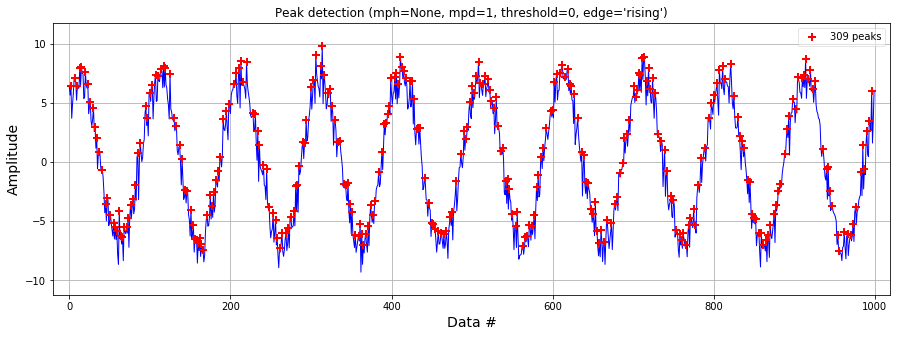

array([  2,   7,  10,  13,  15,  20,  23,  26,  30,  32,  34,  37,  41,
        45,  47,  51,  55,  57,  59,  62,  64,  66,  68,  71,  73,  76,
        79,  82,  85,  88,  95,  97, 100, 103, 107, 110, 114, 117, 119,
       125, 130, 133, 137, 140, 144, 146, 151, 154, 156, 158, 160, 162,
       164, 166, 171, 175, 177, 179, 182, 185, 187, 191, 195, 198, 204,
       207, 211, 213, 215, 220, 228, 231, 234, 236, 241, 245, 248, 253,
       256, 258, 261, 264, 269, 272, 275, 279, 281, 283, 285, 290, 292,
       294, 300, 303, 306, 312, 314, 316, 321, 323, 326, 330, 334, 336,
       341, 343, 346, 349, 351, 355, 359, 361, 363, 365, 368, 371, 374,
       377, 379, 384, 388, 391, 393, 395, 397, 399, 404, 406, 408, 411,
       413, 415, 418, 423, 426, 428, 431, 433, 435, 441, 446, 450, 452,
       454, 458, 462, 465, 468, 473, 475, 480, 486, 490, 492, 494, 497,
       500, 502, 505, 508, 510, 514, 516, 520, 522, 524, 527, 530, 532,
       536, 538, 542, 544, 546, 550, 554, 556, 563, 566, 568, 57

In [146]:
detect_peaks(xn, show=True)

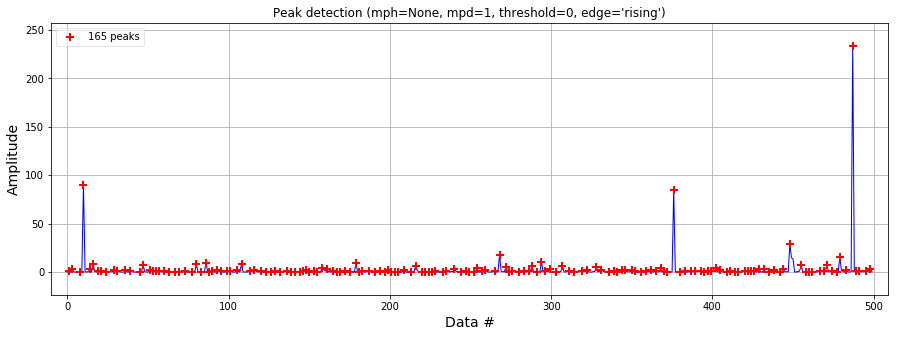

array([  1,   3,   8,  10,  14,  16,  19,  21,  24,  29,  31,  36,  39,
        45,  47,  51,  53,  55,  57,  60,  63,  67,  69,  73,  77,  80,
        83,  86,  88,  90,  93,  95,  99, 101, 105, 108, 113, 116, 120,
       123, 126, 129, 132, 136, 139, 141, 144, 146, 148, 150, 153, 155,
       158, 161, 165, 167, 169, 172, 175, 179, 181, 183, 187, 191, 194,
       197, 199, 201, 203, 205, 209, 213, 216, 220, 222, 224, 226, 228,
       233, 235, 240, 244, 247, 249, 252, 254, 257, 259, 265, 268, 272,
       274, 276, 280, 283, 286, 288, 291, 294, 296, 299, 303, 307, 311,
       314, 319, 322, 328, 331, 336, 339, 341, 344, 346, 350, 352, 356,
       359, 362, 365, 368, 370, 372, 376, 380, 383, 387, 389, 393, 395,
       397, 399, 402, 405, 409, 411, 414, 416, 420, 422, 424, 426, 429,
       432, 435, 438, 442, 444, 448, 455, 458, 460, 462, 467, 469, 471,
       474, 477, 479, 483, 487, 489, 491, 495, 498])

In [147]:
detect_peaks(abs(Y), show=True)

In [0]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
      
      
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)
 
  denominator = 10
  X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
  X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

In [0]:
import pandas as pd

In [0]:
signal = pd.DataFrame(x)
signal['Label'] = 'S'

noise = pd.DataFrame(n)
noise['Label'] = 'N'

raw = pd.DataFrame(xn)
raw['Label'] = 'NS'

concat = pd.concat([signal, noise, raw])